In [1]:
import agents, environments

import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t, mode
from tqdm import tqdm
import cProfile

from utility import print_gridworld_with_policy, print_heatmap, plot_graph

2023-09-04 17:02:32.189291: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-04 17:02:32.267947: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-04 17:02:32.268985: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-04 17:02:33.798478: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Global Variables

In [2]:
confidence = 0.95

# Register the environment

In [3]:
gym.envs.register(
    id='GridworldPOMDPEnvGoalless-v0',
    entry_point=environments.GridworldPOMDPEnvGoalless
)

# Gridworld Vector First

In [4]:
# Number of episodes for the training
n_episodes = 50
n_traj = 100
# Number of runs per episode
n_run = 2
# Define the arguments for each environment
time_horizon = 25
steepness = 15
prob = 0.1
envs = gym.vector.make('GridworldPOMDPEnvGoalless-v0', time_horizon=time_horizon, steepness=steepness, prob=prob, num_envs=n_traj)
env = environments.GridworldPOMDPEnvGoalless(time_horizon = time_horizon, steepness=15, prob=prob)

In [ ]:
def main():
    with tqdm(total=n_run * n_episodes, ncols=80) as pbar:
        # Train the agent and plot the entropies
        list_entropies = []
        list_true_entropies = []
        for r in range(n_run):
            ag = agents.REINFORCEAgentEPOMDPVec(env, alpha=0.5, n_traj=n_traj)  # Modify the agent to accept the parallel environments
            avg_entropies = []
            avg_true_entropies = []
            for i in range(n_episodes):
                trajectories = []
                episodes = [ [] for _ in range(n_traj) ]
                true_entropies = []
                d_t = np.zeros((n_traj, env.observation_space.n))  # Initialize visitation counts for all parallel environments
                true_d_t = np.zeros((n_traj, env.observation_space.n))
                envs.reset()
                done = np.zeros(n_traj, dtype=bool)
                while not np.all(done):
                    # Sample action and get probabilities from the belief
                    actions, probs = ag.get_actions()
                    # Sample state
                    sampled_states = ag.get_states()
                    # Take a step in the parallel environments
                    next_obs, rewards, done, _, true_states = envs.step(actions)
                    # Get the indices of the states for all parallel environments
                    state_indices = [env.state_to_index(state) for state in sampled_states]
                    true_state_indices = true_states['true_state']
                    # Update state visitation counts for all parallel environments
                    for i, state_index in enumerate(state_indices):
                        d_t[i][state_index] += 1
                    for i, true_state_index in enumerate(true_state_indices):
                        true_d_t[i][true_state_index] += 1
                    # Arrange the single trajectories
                    for i in range(n_traj):
                        episodes[i].append((ag.beliefs[i], actions[i], probs[i], rewards[i], true_state_indices[i]))
                    # Update belief
                    ag.belief_update(actions, next_obs)
                # Compute true entropy of the trajectory for all parallel environments
                true_d_t /= time_horizon
                log_true_d_t = -np.log(true_d_t, where=true_d_t>0)
                true_entropies = np.sum(np.multiply(true_d_t, log_true_d_t),axis=1)
                # Compute believed entropy of the trajectory for all parallel environments
                d_t /= time_horizon
                log_d_t = -np.log(d_t, where=d_t>0)
                entropies = np.sum(np.multiply(d_t, log_d_t), axis=1)
                for i in range(n_traj):
                    trajectories.append((episodes[i], d_t[i]))
                ag.update_multiple_sampling(trajectories)
                avg_entropies.append(np.mean(entropies))
                avg_true_entropies.append(np.mean(true_entropies))
                pbar.update(1)
            ag.print_visuals(envs=envs, env=env, n_traj=n_traj)  # Modify the agent to accept the parallel environments
            list_entropies.append(avg_entropies)
            list_true_entropies.append(avg_true_entropies)
        list_entropies = np.transpose(np.array(list_entropies), (1, 0))
        list_true_entropies = np.transpose(np.array(list_true_entropies), (1, 0))

    plot_graph(n_run, n_episodes, list_entropies, list_true_entropies, confidence, 'Example with parallelism')

#main()

if __name__ == "__main__":
    cProfile.run("main()", sort="cumulative")

 50%|█████████████████████                     | 50/100 [00:35<00:35,  1.43it/s]

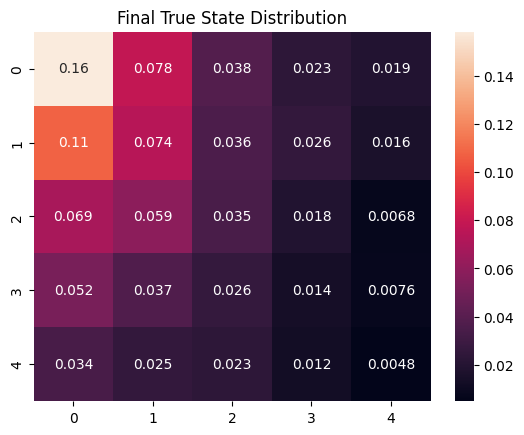

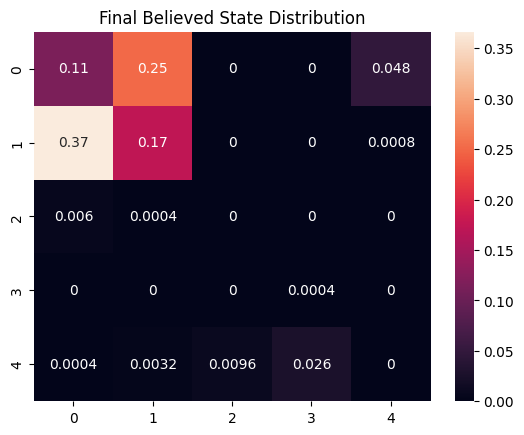

KL divergence(d_t, true_d_t): 0.8773412187096331


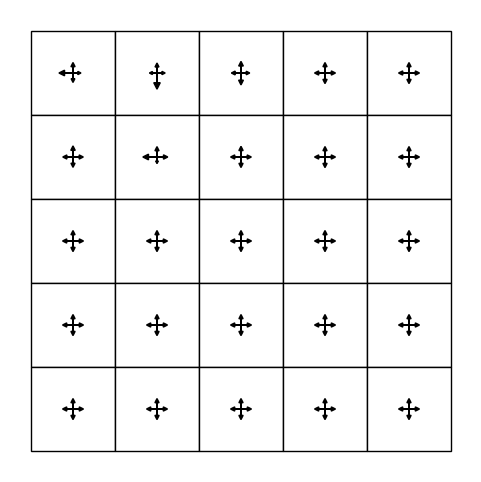

100%|█████████████████████████████████████████| 100/100 [01:12<00:00,  1.42it/s]

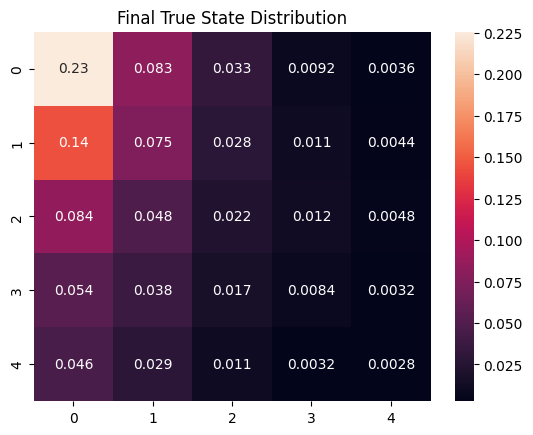

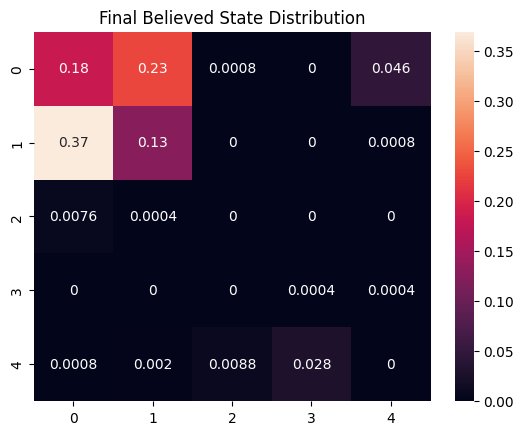

KL divergence(d_t, true_d_t): 0.7421284819459519


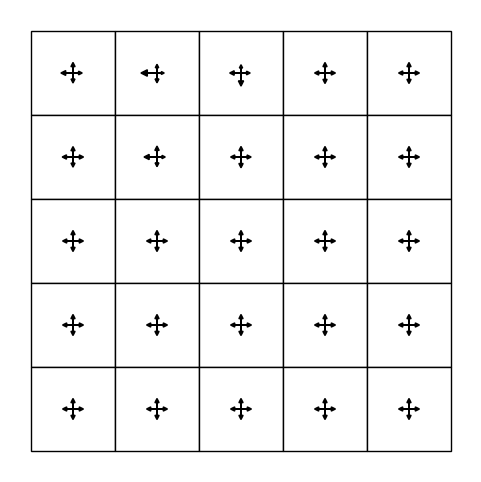

100%|█████████████████████████████████████████| 100/100 [01:14<00:00,  1.34it/s]


         42913026 function calls (42326770 primitive calls) in 74.762 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     11/1    0.000    0.000   74.762   74.762 {built-in method builtins.exec}
        1    0.000    0.000   74.762   74.762 <string>:1(<module>)
        1    0.160    0.160   74.762   74.762 927008859.py:1(main)
      100    2.189    0.022   63.961    0.640 agents.py:539(play)
   255000    1.603    0.000   28.917    0.000 agents.py:519(get_state)
   765000   10.602    0.000   26.847    0.000 random.py:506(choices)
2121529/1587434    2.649    0.000   17.623    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
   765000    8.452    0.000   15.681    0.000 random.py:540(<listcomp>)
   255000    4.299    0.000   12.274    0.000 agents.py:500(belief_update)
   785206    1.220    0.000   11.738    0.000 <__array_function__ internals>:177(sum)
   255000    1.216    0.000   11.581    0.

AttributeError: 'numpy.ndarray' object has no attribute 'items'

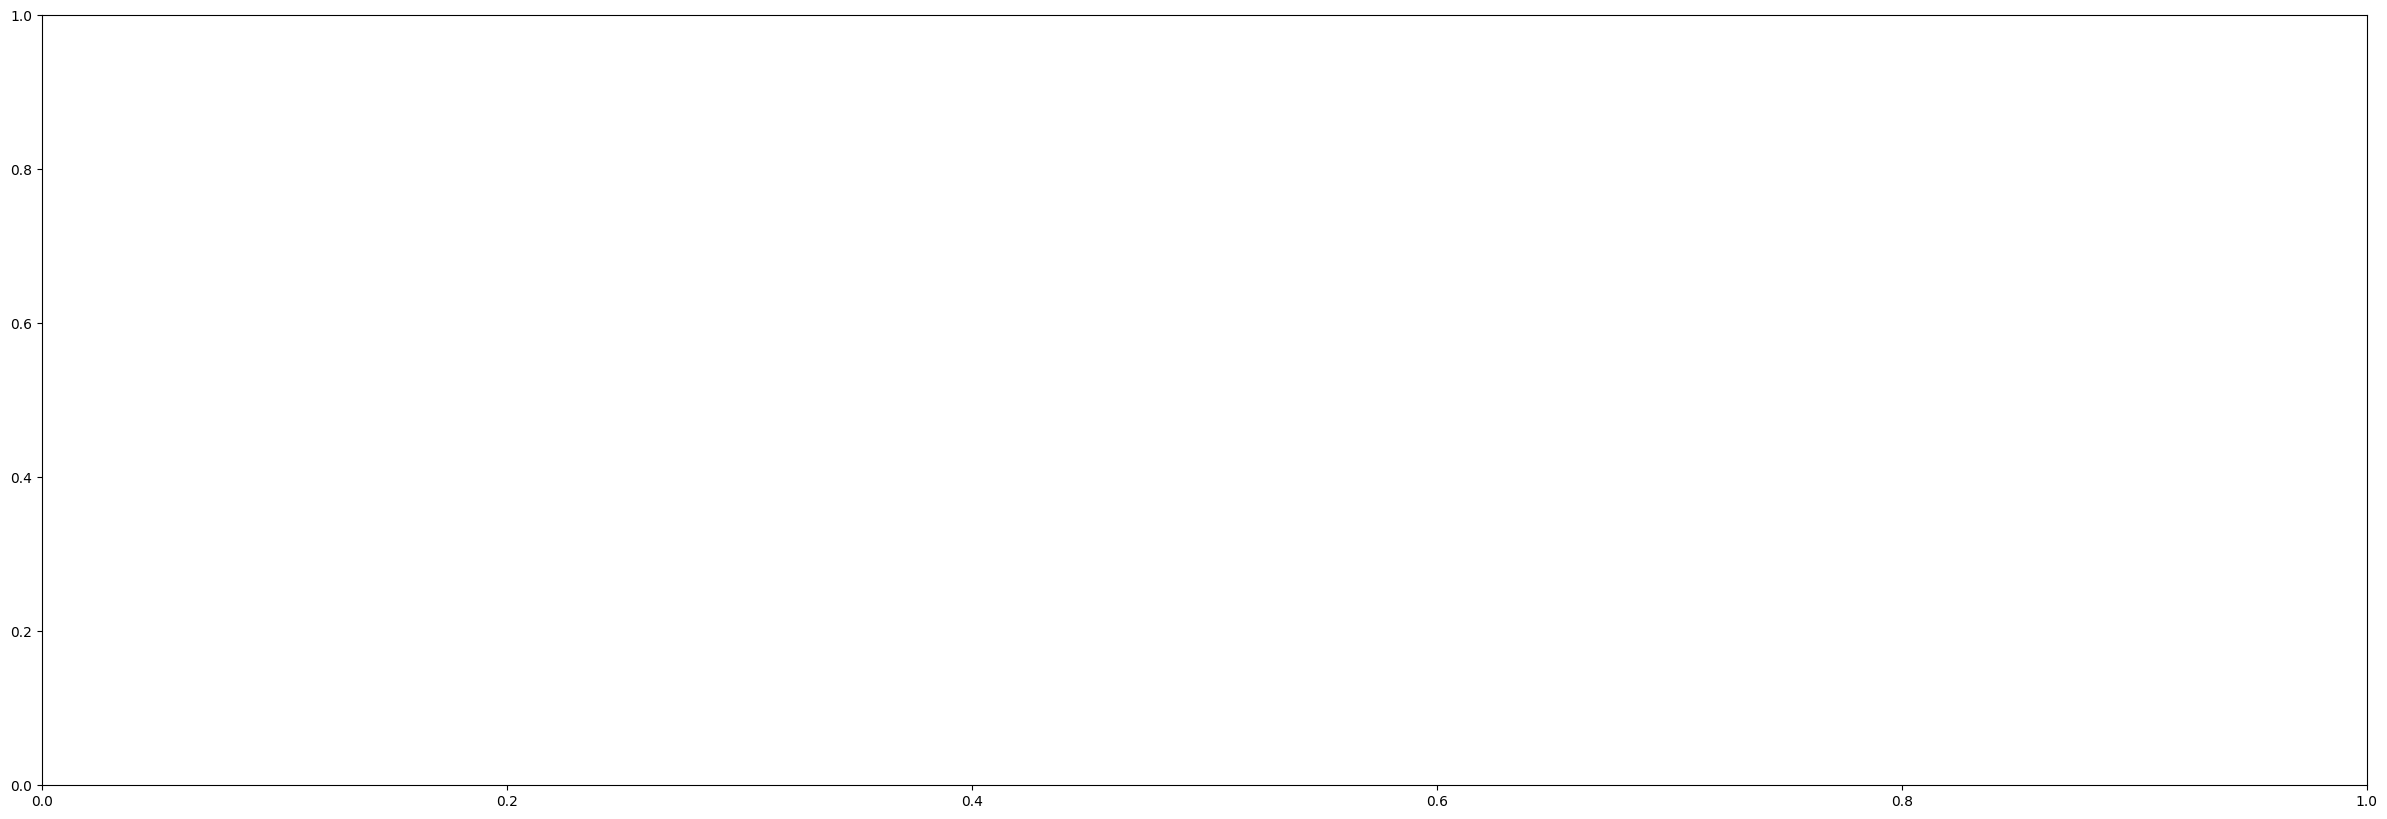

In [6]:
def main():
    with tqdm(total=n_run * n_episodes, ncols=80) as pbar:
        # Train the agent and plot the entropies
        list_entropies = []
        list_true_entropies = []
        for r in range(n_run):
            ag = agents.REINFORCEAgentEPOMDP(env, alpha = 0.25)
            avg_entropies = []
            avg_true_entropies = []
            for i in range(n_episodes):
                episodes, true_entropies = ag.play(env=env, n_traj=n_traj)
                entropies = ag.update_multiple_sampling(episodes)
                avg_entropies.append(np.mean(entropies))
                avg_true_entropies.append(np.mean(true_entropies))
                pbar.update(1)
            ag.print_visuals(env=env, n_traj=n_traj)
            list_entropies.append(avg_entropies)
            list_true_entropies.append(avg_true_entropies)
        list_entropies = np.transpose(np.array(list_entropies), (1,0))
        list_true_entropies = np.transpose(np.array(list_true_entropies), (1,0))

    plot_graph(n_run, n_episodes, list_entropies, list_true_entropies, confidence, 'Example sequential')

# main()

if __name__ == "__main__":
    cProfile.run("main()", sort="cumulative")